In [135]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.preprocessing import LabelEncoder

In [136]:
df = pd.read_csv("~/Projects/omscs/ML/income_evaluation.csv")
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.dropna()
df = df.ffill()
df = df.bfill()
df.shape
df.columns = list(map(lambda x: x.strip(), df.columns))

In [ ]:
sns.pairplot(df, hue="income", height=3)

In [137]:
# Convert the output class into buckets of low and high. Low is 0 and high is 1
df.columns
price_range = df[['income']].to_numpy()
price_range[price_range=="<=50K"] = 0

price_range[price_range==">50K"] = 1
y_new = pd.DataFrame(price_range, columns=['income'])
# for i in df.columns:
#     print(df[[i]].value_counts())
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [152]:
# Do a one-hot encoding of string features - otherwise the predict method will fail
for i in df.columns:
    if i in ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
        df[i] = LabelEncoder().fit_transform(df[i])


In [103]:
X = df.drop(columns=['income', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss'])
y = y_new
y=y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
df[['income']].value_counts()

income
0         24720
1          7841
dtype: int64

In [102]:
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(x_train, y_train)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
print(f"Number of Nodes in the tree {clf.tree_.node_count}")
print(f"Features of Model Tree are : dir{dir(clf.tree_)}")

DT Normal Model: Fit Time: 0.09337925910949707
DT Normal Model: Fit Time: 0.003942966461181641
Number of Nodes in the tree 11229
Features of Model Tree are : dir['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'apply', 'capacity', 'children_left', 'children_right', 'compute_feature_importances', 'compute_partial_dependence', 'decision_path', 'feature', 'impurity', 'max_depth', 'max_n_classes', 'n_classes', 'n_features', 'n_leaves', 'n_node_samples', 'n_outputs', 'node_count', 'predict', 'threshold', 'value', 'weighted_n_node_samples']


In [80]:
from sklearn.model_selection import cross_val_score
crossValScores = cross_val_score(clf, X, y, cv=5)
print("Cross Valuation Scores for unpruned tree are ", crossValScores)
print("Mean accuracy score is ", crossValScores.mean())
print("Std accuracy score is ", crossValScores.std())

Cross Valuation Scores for unpruned tree are  [0.77905727 0.77748771 0.78025184 0.78516585 0.77779484]
Mean accuracy score is  0.7799515031550959
Std accuracy score is  0.002785702503062096


In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4950
           1       0.52      0.53      0.52      1563

    accuracy                           0.77      6513
   macro avg       0.69      0.69      0.69      6513
weighted avg       0.77      0.77      0.77      6513



In [82]:
print(confusion_matrix(y_test, y_pred))

[[4198  752]
 [ 742  821]]


In [83]:
# To make the results deterministic - we need to use random_state
pipelineA = Pipeline([('scaler', StandardScaler()), 
#                       ('Cull1',SelectFromModel(RandomForestClassifier(random_state=1),threshold='median')),
#                       ('Cull2',SelectFromModel(RandomForestClassifier(random_state=2),threshold='median')),
#                       ('Cull3',SelectFromModel(RandomForestClassifier(random_state=3),threshold='median')),
#                       ('Cull4',SelectFromModel(RandomForestClassifier(random_state=4),threshold='median')),
                      ('dt', DecisionTreeClassifier())])
start_time = time.time()
p = pipelineA.fit(x_train, y_train)
print(f"DT Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipelineA = p.predict(x_test)
print(f"DT Pipeline Model: Predict Time: {time.time() - start_time}")
# print(confusion_matrix(y_test, y_pred_pipelineA))
# print(classification_report(y_test, y_pred_pipelineA))

DT Pipeline Model: Fit Time: 0.09839797019958496
DT Pipeline Model: Predict Time: 0.004045963287353516


In [105]:
# Cross validation 
# Use np.arange(1, 20, 5)
# => 1, 5, 10, 15, 20
ccp_alphas = [-1,-1e-3,-(1e-3)*10**-0.5, -1e-2, -(1e-2)*10**-0.5,-1e-1,-(1e-1)*10**-0.5, 0, (1e-1)*10**-0.5,1e-1,(1e-2)*10**-0.5,1e-2,(1e-3)*10**-0.5,1e-3]
param = {'dt__max_depth': np.arange(1, 20), 'dt__criterion': ['gini', 'entropy'], 'dt__ccp_alpha': ccp_alphas, 'dt__class_weight': ['balanced']}
clf_cv = GridSearchCV(pipelineA, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True)
start_time = time.time()
clf_cv = clf_cv.fit(x_train, y_train)
print(f"DT CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test)
print(f"DT CV Model: Predict Time: {time.time() - start_time}")

DT CV Model: Fit Time: 33.911014795303345
DT CV Model: Predict Time: 0.0051038265228271484


In [106]:
start_time = time.time()
print(classification_report(y_test, y_pred_pipeline_cv))
print(clf_cv.best_score_, clf_cv.best_params_)
print(f"DT CV classification_report time: {time.time() - start_time}")
# print(clf_cv.cv_results_)
sc_df = pd.DataFrame(clf_cv.cv_results_)
sc_df.dropna(inplace=True)
sc_df.sort_values(by="rank_test_score", ascending=True)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      4945
           1       0.53      0.79      0.63      1568

    accuracy                           0.78      6513
   macro avg       0.73      0.78      0.74      6513
weighted avg       0.83      0.78      0.79      6513

0.7779868889258184 {'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__max_depth': 7}
DT CV classification_report time: 0.014672994613647461


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__ccp_alpha,param_dt__class_weight,param_dt__criterion,param_dt__max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
502,0.092082,0.014648,0.004739,0.000858,0.001,balanced,gini,9,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': '...",0.780038,...,0.777987,0.007194,1,0.773875,0.772819,0.787600,0.779644,0.785258,0.779839,0.005907
506,0.109113,0.007999,0.004979,0.000645,0.001,balanced,gini,13,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': '...",0.780038,...,0.777987,0.007194,1,0.773875,0.772819,0.787600,0.779644,0.785258,0.779839,0.005907
507,0.115585,0.007448,0.005322,0.001462,0.001,balanced,gini,14,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': '...",0.780038,...,0.777987,0.007194,1,0.773875,0.772819,0.787600,0.779644,0.785258,0.779839,0.005907
508,0.122481,0.010794,0.005673,0.000968,0.001,balanced,gini,15,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': '...",0.780038,...,0.777987,0.007194,1,0.773875,0.772819,0.787600,0.779644,0.785258,0.779839,0.005907
509,0.143171,0.012966,0.005924,0.002277,0.001,balanced,gini,16,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': '...",0.780038,...,0.777987,0.007194,1,0.773875,0.772819,0.787600,0.779644,0.785258,0.779839,0.005907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.121776,0.019080,0.006325,0.002364,0.1,balanced,gini,13,"{'dt__ccp_alpha': 0.1, 'dt__class_weight': 'ba...",0.613436,...,0.604115,0.006267,217,0.601785,0.603033,0.605096,0.604396,0.606267,0.604115,0.001567
355,0.118705,0.013732,0.005395,0.001402,0.1,balanced,gini,14,"{'dt__ccp_alpha': 0.1, 'dt__class_weight': 'ba...",0.613436,...,0.604115,0.006267,217,0.601785,0.603033,0.605096,0.604396,0.606267,0.604115,0.001567
356,0.132584,0.015136,0.006063,0.001360,0.1,balanced,gini,15,"{'dt__ccp_alpha': 0.1, 'dt__class_weight': 'ba...",0.613436,...,0.604115,0.006267,217,0.601785,0.603033,0.605096,0.604396,0.606267,0.604115,0.001567
358,0.145598,0.008187,0.005776,0.000878,0.1,balanced,gini,17,"{'dt__ccp_alpha': 0.1, 'dt__class_weight': 'ba...",0.613436,...,0.604115,0.006267,217,0.601785,0.603033,0.605096,0.604396,0.606267,0.604115,0.001567


In [107]:
# Pruning the DT

In [130]:
def plot_grid_search_validation_curve(grid, param_to_vary, title='Validation Curve', ylim=None, xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
#     if (not isinstance(param_range[0], numbers.Number)):
#         param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score', color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='b', lw=lw)

    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

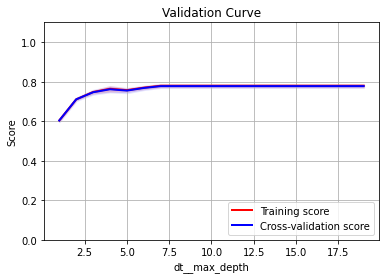

{'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__max_depth': 7}


In [131]:
plot_grid_search_validation_curve(clf_cv, 'dt__max_depth', log=False)
print(clf_cv.best_params_)

<module 'matplotlib.pyplot' from '/Users/nitarora/Projects/KBAI-Assignment1/venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

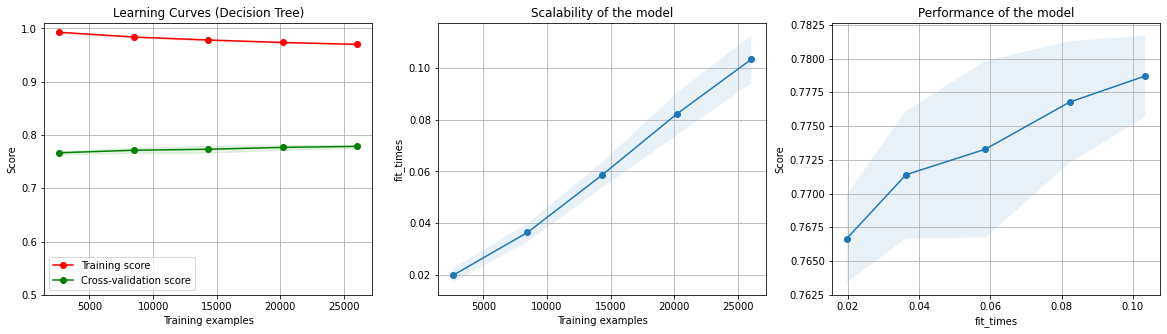

In [129]:
import numpy as np
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)
plot_learning_curve(clf_cv.estimator, title, X, y,  ylim=(0.5, 1.01), cv=cv, n_jobs=4)

Automatically created module for IPython interactive environment


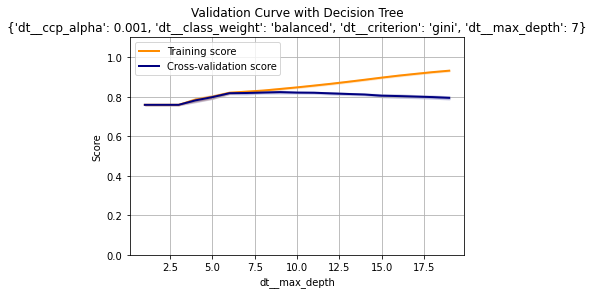

In [133]:
print(__doc__)

from sklearn.model_selection import validation_curve

param_range = np.arange(1, 20, 1)
train_scores, test_scores = validation_curve(clf_cv.estimator, X, y, param_name="dt__max_depth", param_range=param_range,scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title(f"Validation Curve with Decision Tree\n{clf_cv.best_params_}")
plt.xlabel(r"dt__max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.grid()
plt.show()

KeyboardInterrupt: 

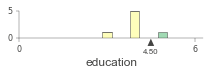

In [87]:
# from dtreeviz.trees import dtreeviz
# viz = dtreeviz(clf, X, y['income'],
#                 target_name="income",
#                 feature_names=df.columns.tolist(),
#                 class_names=['low', 'high'])
# viz.view()

In [ ]:
feature_columns = (df.columns.tolist())
feature_columns.remove('income')
dot_data = StringIO()

out_file = export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_columns, class_names=['Very Low', 'Low', 'High','Very High'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('output_income.png')

Image(graph.create_png())